In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from mean_average_precision import MetricBuilder


from wsddn import *

In [2]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data', image_set='train', download=False, transform=transform_train)
test_set = CustomVOC('../edge_boxes_model/model.yml.gz', eval_mode=True, root='../../../data', image_set='val', download=False, transform=transform_test)

def my_collate(batch):
    data = [item[0] for item in batch]
    label = [item[1] for item in batch]
    boxes = [item[2] for item in batch]
    if (len(batch[0]) == 4):
        gt_boxes = [item[3] for item in batch]
        return data, label, boxes, gt_boxes
    return data, label, boxes

train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0, collate_fn=my_collate)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, num_workers=0, collate_fn=my_collate)

In [14]:
for i, stacked_data in enumerate(train_loader):
    pass

KeyboardInterrupt: 

In [6]:
img, label, boxes = train_set[3585]

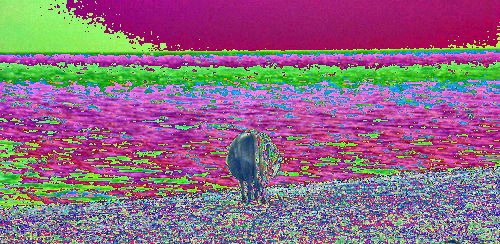

In [7]:
transforms.ToPILImage()(img)

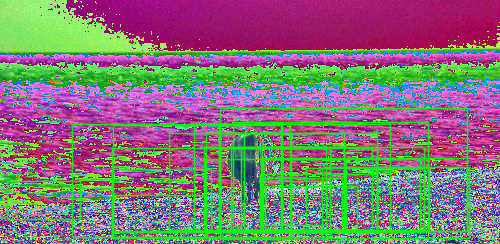

In [9]:
train_set.draw_raw_boxes(transforms.ToPILImage()(img), boxes)

In [10]:
class DebugCustomVOC(datasets.VOCDetection):
    """Custom dataset that also generates boxes for each image"""
    def __init__(self, edge_model, eval_mode=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_boxes = EdgeBoxes(edge_model)
        self.label_names = [
            'background',
            'aeroplane',
            'bicycle',
            'bird',
            'boat',
            'bottle',
            'bus',
            'car',
            'cat',
            'chair',
            'cow',
            'diningtable',
            'dog',
            'horse',
            'motorbike',
            'person',
            'pottedplant',
            'sheep',
            'sofa',
            'train',
            'tvmonitor'
        ]

        self.eval_mode = eval_mode

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        boxes = self.edge_boxes(image)
        if isinstance(boxes, tuple):
            # print(boxes)
            # boxes = torch.tensor([])
            print(index)
            print(label)
            # raise ValueError("Why? We are going to find out.")
            return image
        else:
            boxes = transforms.ToTensor()(boxes.astype('float32')).view([len(boxes), 4])

        one_hot_label = torch.zeros(len(self.label_names))
        # one_hot_label = torch.ones(len(self.label_names)) * -1
        for obj in label['annotation']['object']:
            one_hot_label[self.label_names.index(obj['name'])] = 1

        if torch.sum(one_hot_label) == -len(self.label_names):
            # Background
            one_hot_label[0] = 1


        if self.eval_mode:
            gt_boxes = []
            for obj in label['annotation']['object']:
                label_index = self.label_names.index(obj['name'])
                bbox = obj['bndbox']
                gt_boxes.append([
                    int(bbox['xmin']), 
                    int(bbox['ymin']), 
                    int(bbox['xmax']), 
                    int(bbox['ymax']), 
                    label_index, 
                    int(obj['difficult']), 
                    0
                ])

            return image, one_hot_label, boxes, gt_boxes

        return image, one_hot_label, boxes


In [11]:
voc_set = DebugCustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data', image_set='train', download=False, transform=None)

In [12]:
img, label, boxes = voc_set[3585]

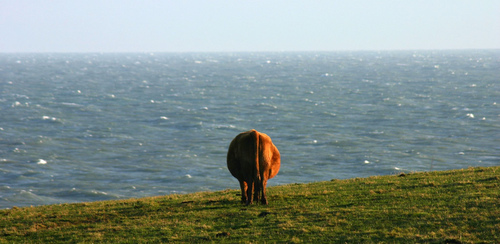

In [13]:
img

In [38]:
class EdgeBoxes():
    def __init__(self, model_path, max_boxes=30):
        self.edge_detection = cv.ximgproc.createStructuredEdgeDetection(model_path)
        self.edge_boxes = cv.ximgproc.createEdgeBoxes()
        self.edge_boxes.setMaxBoxes(30)
        # self.model_path = model_path
        # self.max_boxes = max_boxes

    def __call__(self, image, ret_scores=False):
        cv_img = image
        if not isinstance(image, torch.Tensor):
            cv_img = transforms.PILToTensor()(cv_img)
        cv_img = cv_img.permute((1,2,0)).numpy()
        rgb_im = cv.cvtColor(cv_img, cv.COLOR_BGR2RGB)
        edges = self.edge_detection.detectEdges(np.float32(rgb_im) / 255.0)
        orimap = self.edge_detection.computeOrientation(edges)
        edges = self.edge_detection.edgesNms(edges, orimap)
        boxes = self.edge_boxes.getBoundingBoxes(edges, orimap)
        print(boxes)
        # OpenCV returns (x, y, w, h). Shift to be (x1, y1, x2, y2)
        for b in boxes[0]:
            b[2] += b[0]
            b[3] += b[1]
            
        if ret_scores:
            return boxes[0], boxes[1]
        
        return boxes[0]

In [39]:
EdgeBoxes('../edge_boxes_model/model.yml.gz')(fault_img)

((), None)


()